In [1]:
import numpy as np
import pandas as pd

from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

from ast import literal_eval 
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score, adjusted_rand_score, fowlkes_mallows_score, calinski_harabasz_score
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet, fcluster
from scipy.spatial.distance import pdist
import scipy.cluster.hierarchy as shc
from sklearn.decomposition import PCA

import plotly.express as px
import plotly.graph_objects as go

from functions import get_recommendations


In [2]:
materials = pd.read_csv('../datasets/clean_data/materials_clean.csv')

# Feature Engineering & Feature Selection

In [3]:
materials.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1539 entries, 0 to 1538
Data columns (total 43 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   id                               1539 non-null   int64  
 1   created_at                       1539 non-null   object 
 2   updated_at                       1539 non-null   object 
 3   code                             1539 non-null   object 
 4   fabric_weave                     1539 non-null   object 
 5   currency                         1539 non-null   object 
 6   supplier_id                      1539 non-null   int64  
 7   price                            1539 non-null   float64
 8   name                             1539 non-null   object 
 9   fabric_blend_one                 1539 non-null   object 
 10  fabric_blend_one_percent         1539 non-null   float64
 11  fabric_blend_two                 1539 non-null   object 
 12  fabric_blend_two_per

In [4]:
materials.shape

(1539, 43)

In [5]:
# Drop columns that don't seem necessary for content based recommendations

materials_dm = materials.drop(columns=['id', 'name', 'description', 'fabric_blend_one_percent', 'fabric_blend_two_percent', 'fabric_blend_three_percent', 
                                  'fabric_weave', 'fabric_type', 
                                  'fabric_blend_two', 'fabric_blend_three', 'created_at', 'swatch_price', 
                                    'updated_at', 'code', 'currency', 'weight_unit', 
                                    'price_unit', 'status', 'only_for_brands', 'published', 
                                'dispatch_time_sample', 'width', 'width_unit', 
                                'finishing', 'dispatch_time_mass_quantity_min', 'dispatch_time_mass_quantity_max', 
                                    'uuid', 'notify_fc_team', 'moq', 'swatch_price', 'swatch_quantity', 
                                'supp_name', 'supp_fabric_type', 'supp_specialty', 'supp_fibers', 'supp_end_uses',
                                'factory_location', 'minimal_order_quantity'
                                 ])

materials2_dm = materials.drop(columns=['id', 'name', 'description', 'fabric_blend_one_percent', 'fabric_blend_two_percent', 'fabric_blend_three_percent', 
                                  'fabric_weave', 'fabric_type', 
                                  'fabric_blend_two', 'fabric_blend_three', 'created_at', 'swatch_price', 
                                    'updated_at', 'code', 'currency', 'weight_unit', 
                                    'price_unit', 'status', 'only_for_brands', 'published', 
                                'dispatch_time_sample', 'width', 'width_unit', 
                                'finishing', 'dispatch_time_mass_quantity_min', 'dispatch_time_mass_quantity_max', 
                                    'uuid', 'notify_fc_team', 'moq', 'swatch_price', 'swatch_quantity', 
                                'supp_name', 'supp_fabric_type', 'supp_specialty', 'supp_fibers', 'supp_end_uses',
                                'factory_location', 'minimal_order_quantity', 'properties', 'supplier_id'
                                 ])

In [6]:
materials_dm

,supplier_id,price,fabric_blend_one,weight,properties,end_use
0,23,11.90,Organic Cotton,310.0,[],"['Coat', 'Jacket', 'Pants']"
1,25,13.52,TENCEL Lyocell,0.0,[],"['Dress', 'Pants', 'Skirt']"
2,27,1.80,Organic Cotton,134.0,[],['Shirt']
3,44,15.90,Organic Cotton,460.0,[],"['Sweatshirt', 'Leggings / Yoga Pants', 'Blous..."
4,67,32.00,Recycled Cow Leather,800.0,[],"['Bags & Wallets', 'Shoes']"
...,...,...,...,...,...,...
1534,54,170.00,Pirarucu (fish skin),0.0,[],"['Bags & Wallets', 'Caps & Hats', 'Shoes', 'Ja..."
1535,54,252.00,Pirarucu (fish skin),0.0,[],"['Bags & Wallets', 'Caps & Hats', 'Shoes', 'Ja..."
1536,68,10.30,Recycled Nylon,165.0,"['Water Repellent (W/R)', 'Waterproof (W/P)']","['Jacket', 'Pants', 'Shirt', 'Skirt', 'Shorts']"
1537,68,3.50,Recycled Polyester,90.0,"['Durable Water Repellent (DWR)', 'Waterproof ...","['Jacket', 'Pants', 'Shirt', 'Skirt', 'Shorts']"


## One-hot encoding

In [7]:
# One hot encoding won't work on fields where values are lists e.g. end_use, properties
# This function separates the list values and one hot encodes them
def dummify_list_cols(dataset, col_name):
    
    out_dataset = dataset.copy()
    out_dataset[col_name] = out_dataset[col_name].apply(literal_eval)
    full_list = list(set(out_dataset[col_name].sum()))
    
    for col in full_list:
        out_dataset[col] = out_dataset[col_name].apply(lambda x: 1 if col in x else 0)

    out_dataset.drop(columns=[col_name], inplace=True)
    
    return out_dataset


In [8]:
materials_dm = dummify_list_cols(materials_dm, 'end_use')
materials2_dm = dummify_list_cols(materials2_dm, 'end_use')

In [9]:
materials_dm = dummify_list_cols(materials_dm, 'properties')

In [10]:
# One-hot encoding on other categorical variables

materials_dm = pd.get_dummies(materials_dm, columns=[ 
                                   'fabric_blend_one', 'supplier_id'], drop_first=True)

materials2_dm = pd.get_dummies(materials2_dm, columns=[ 
                                   'fabric_blend_one'], drop_first=True)


In [11]:
# Scale our dataset for Clustering using standard scaler
X1 = materials_dm
ss = StandardScaler()
X1_sc = ss.fit_transform(X1)

# Scale our dataset using MinMax scaler for cosine similarity
# This is done because Standard Scaler gives negative values  
#for some cases and this causes negative cosine similarity values
mm = MinMaxScaler()
X1_mm = mm.fit_transform(X1)

In [12]:
df_X1_sc = pd.DataFrame(X1_sc, index=materials_dm.index,  columns=materials_dm.columns)
df_X1_mm = pd.DataFrame(X1_mm, index=materials_dm.index,  columns=materials_dm.columns)

In [13]:
# Scale our dataset for Clustering using standard scaler
X2 = materials2_dm
ss = StandardScaler()
X2_sc = ss.fit_transform(X2)

# Scale our dataset for MinMax scaler for cosine similarity
# This is done because Standard Scaler gives negative values  
#for some cases and this causes negative cosine similarity values
mm = MinMaxScaler()
X2_mm = mm.fit_transform(X2)

In [14]:
df_X2_sc = pd.DataFrame(X2_sc, index=materials2_dm.index, columns=materials2_dm.columns)
df_X2_mm = pd.DataFrame(X2_mm, index=materials2_dm.index, columns=materials2_dm.columns)

# Clustering

Cluster analysis, or clustering, is an unsupervised machine learning task which involves automatically discovering natural grouping in data. We will use unsupervised clustering methods to try and cluster similar materials and recommend materials from the same cluster as the input material. 

## KMeans Clustering

### Materials 

In [15]:
# Function to fit Kmeans and return the resulting labels, inertia and silhouette scores
def fit_kmeans(X_dataset, no_of_clusters):
    km = KMeans(n_clusters=no_of_clusters, random_state=123)
    km.fit(X_dataset)
    
    return [km.labels_, km.inertia_, silhouette_score(X_dataset, km.labels_)]

In [16]:
# Loop through k values form 2 to 60 and fit K means to find ideal k
def fit_loop_kmeans(X_dataset):
    scores = []
    for k in range(2, 60):
        labels, inertia, silhoette = fit_kmeans(X_dataset, k)

        # find the number of unique labels which is the cluster count
        unique_labels_count= len(np.unique(labels))

        # Find the size of the biggest cluster (other than outliers)
        other_label_values, other_label_count = np.unique(labels[np.where(labels != -1)], return_counts=True)
        max_cluster_count = other_label_count[np.argmax(other_label_count)]

        scores.append([k, inertia, silhoette, unique_labels_count, max_cluster_count])

    score_df = pd.DataFrame(scores)
    score_df.columns = ['k', 'inertia', 'silhouette', 'cluster_count', 'biggest_cluster_count']

    plt.rcParams.update({'font.size': 16})

    fig, axes = plt.subplots(1, 2, figsize=(14, 7))
    axes[0].plot(score_df.k, score_df.inertia)
    axes[0].set_title('Inertia over k')
    axes[1].plot(score_df.k, score_df.silhouette);
    axes[1].set_title('Silhouette Score over k')
    
    return score_df


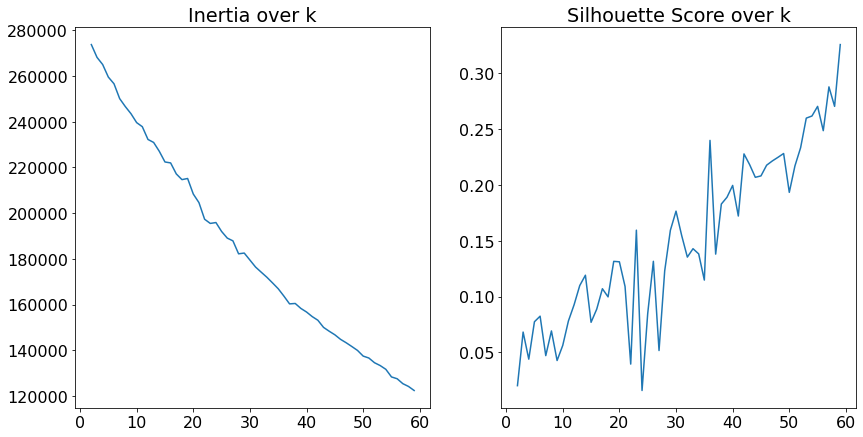

In [17]:
score1_kmeans_df = fit_loop_kmeans(X1_sc)

No elbow is found in the inertia graph, and silhoette score is also not very high

In [18]:
score1_kmeans_df
score1_kmeans_df.sort_values('biggest_cluster_count', ascending=True)

,k,inertia,silhouette,cluster_count,biggest_cluster_count
50,52,134535.374190,0.233251,52,177
56,58,124158.657483,0.270253,58,204
57,59,122383.258581,0.325555,59,214
55,57,125377.317392,0.287690,57,223
53,55,128321.722874,0.270234,55,223
52,54,131649.589407,0.261599,54,254
51,53,133297.923154,0.259725,53,254
39,41,154719.704202,0.172083,41,280
54,56,127523.184006,0.248481,56,282
44,46,144768.381550,0.217580,46,286


In [19]:
# Fit the model with the best K
labels, inertia, silhoette = fit_kmeans(X1_sc, 59)

# attach predicted cluster to original points
materials['cluster_km'] = labels

print(f"silhoette {silhoette}")
print(f"inertia {inertia}")

silhoette 0.32555459992953695
inertia 122383.25858054044


In [20]:
len(materials['cluster_km'].value_counts())

59

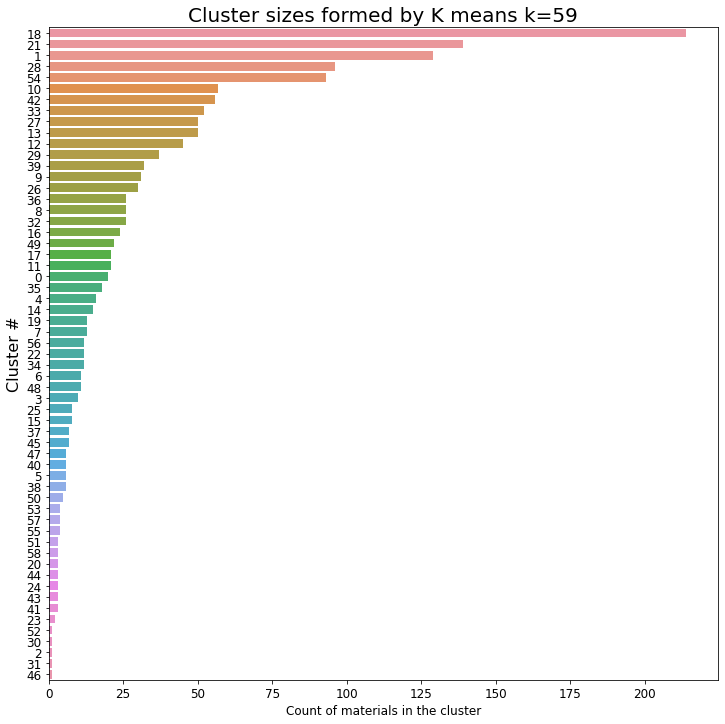

In [21]:
plt.figure(figsize=(12,12))
sort_order = materials.groupby("cluster_km")["id"].count().sort_values(ascending=False).index

plt.rcParams.update({'font.size': 12})


cp = sns.countplot(data=materials, y="cluster_km", order=sort_order)
cp.set_title("Cluster sizes formed by K means k=59", fontsize=20);
cp.set_xlabel("Count of materials in the cluster", fontsize=12);
cp.set_ylabel("Cluster #", fontsize=16);



Even with best k we get very varied cluster sizes, the biggets cluster size is 204 and smallest is 1. For rally big cluster counts it will be difficult to get accurate recommendations. 

### Materials Without Properties

Since properties has many missing columns we try to see if using the dataset without properties gives better reuslts.

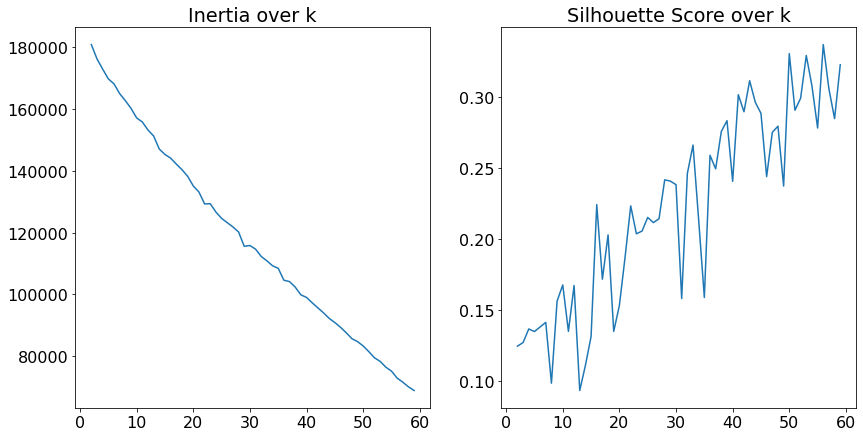

In [22]:
score2_kmeans_df = fit_loop_kmeans(X2_sc)

No elbow is found in the inertia graph, and silhoette score is also not very high

In [23]:
score2_kmeans_df.sort_values('biggest_cluster_count', ascending=True)

,k,inertia,silhouette,cluster_count,biggest_cluster_count
31,33,110878.984424,0.266036,33,446
57,59,68960.242163,0.322642,59,454
51,53,78365.979170,0.329159,53,457
38,40,99045.497486,0.240500,40,502
50,52,79523.153085,0.299042,52,506
49,51,81512.846730,0.290574,51,507
36,38,102377.259627,0.275662,38,514
35,37,104160.039326,0.249280,37,523
56,58,70131.399434,0.284694,58,528
46,48,85723.673771,0.279347,48,530


In [24]:
# Fit the model with the best k
labels, inertia, silhoette = fit_kmeans(X2_sc, 58)

# attach predicted cluster to original points
materials2_dm['cluster_km'] = labels

print(f"silhoette {silhoette}")
print(f"inertia {inertia}")

silhoette 0.28469420403581014
inertia 70131.39943399165


In [25]:
materials2_dm['cluster_km'].value_counts()

0     528
22    156
5      93
45     85
19     74
52     57
27     50
1      45
2      45
13     34
10     33
23     26
12     25
31     24
7      22
24     21
39     20
16     20
42     19
33     15
14     12
26     12
18     12
51     10
29      9
9       8
4       6
20      6
34      6
40      6
30      5
56      5
41      5
28      4
54      4
49      4
11      3
21      3
36      3
50      3
48      2
37      2
3       2
55      1
53      1
6       1
8       1
25      1
47      1
32      1
46      1
44      1
43      1
15      1
38      1
17      1
35      1
57      1
Name: cluster_km, dtype: int64

Even with best k we get very varied cluster sizes, the biggets cluster size is 306 and smallest is 1. For really big cluster counts it will be difficult to get accurate recommendations. 

## DBSCAN Clustering

In [26]:
def fit_dbscan(X_dataset, eps_val, min_samples_val):
    dbscan = DBSCAN(eps=eps_val, min_samples=min_samples_val)
    dbscan.fit(X_dataset);
    return dbscan.labels_, silhouette_score(X_dataset, dbscan.labels_)

### Materials

In [27]:
def fit_loop_dbscan(X_dataset):
    scores = []
    for eps_value in np.arange(0.5, 10, 0.5):
        for min_samples_value in  range(4, 10, 1):
            labels, silhouette = fit_dbscan(X_dataset, eps_value, min_samples_value)
            
            # find the number of unique labels which is the cluster count
            unique_labels_count= len(np.unique(labels))

            # Find how many data points will be considered outliers
            outlier_count = np.count_nonzero(labels == -1)
            
            # Find the size of the biggest cluster (other than outliers)
            other_label_values, other_label_count = np.unique(labels[np.where(labels != -1)], return_counts=True)
            max_cluster_count = other_label_count[np.argmax(other_label_count)]
            std_dev_clusters = np.std(labels)
            
            scores.append([eps_value, min_samples_value, silhouette, unique_labels_count, outlier_count, max_cluster_count, std_dev_clusters])
            
    scores_df = pd.DataFrame(scores, columns = ['eps', 'min_samples', 'silhouette', 'cluster_count', 'outlier_count', 'biggest_cluster_count', 'cluster_std_dev'])
    
    plt.rcParams.update({'font.size': 10})
    lp = sns.lineplot(data=scores_df, x='min_samples', y='silhouette', hue='eps');
    lp.set_title('Silhouette Score over eps, min_samples')

    return scores_df

In [28]:
X1_sc.shape

(1539, 183)

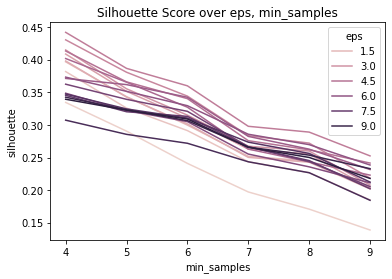

In [29]:
# Call DBScan for various EPS and min_sample values for Materials
scores1_dbscan_df = fit_loop_dbscan(X1_sc)


We get slightly better silhoette score than kmeans for DB Scan. However i is still lower than 0.5. Let's look at the biggest cluster sizes. 

In [30]:
# Look for a model with a high silhouette score and the lowest outlier_count, biggest_cluster_count, cluster_std_dev 
scores1_dbscan_df[scores1_dbscan_df['outlier_count'] + scores1_dbscan_df['biggest_cluster_count'] <= 700].sort_values('silhouette', ascending=False)[0:50]


,eps,min_samples,silhouette,cluster_count,outlier_count,biggest_cluster_count,cluster_std_dev
42,4.0,4,0.441939,85,502,113,28.087439
36,3.5,4,0.430429,85,540,113,28.361791
30,3.0,4,0.414894,83,585,113,28.221192
48,4.5,4,0.413340,81,475,128,25.821730
54,5.0,4,0.401788,80,423,189,25.038226
43,4.0,5,0.386682,66,579,113,21.631213
66,6.0,4,0.373267,69,355,341,20.138806
49,4.5,5,0.365977,64,543,128,20.126044
55,5.0,5,0.365510,67,476,189,20.695490


In [31]:
labels1, sil1 = fit_dbscan(X1_sc, 4, 4)
np.std(labels1)

28.08743918980621

In [32]:
sil1

0.4419392588545873

In [33]:
# attach predicted cluster to original points
materials['cluster_dbscan1'] = labels1
len(materials['cluster_dbscan1'].value_counts())

85

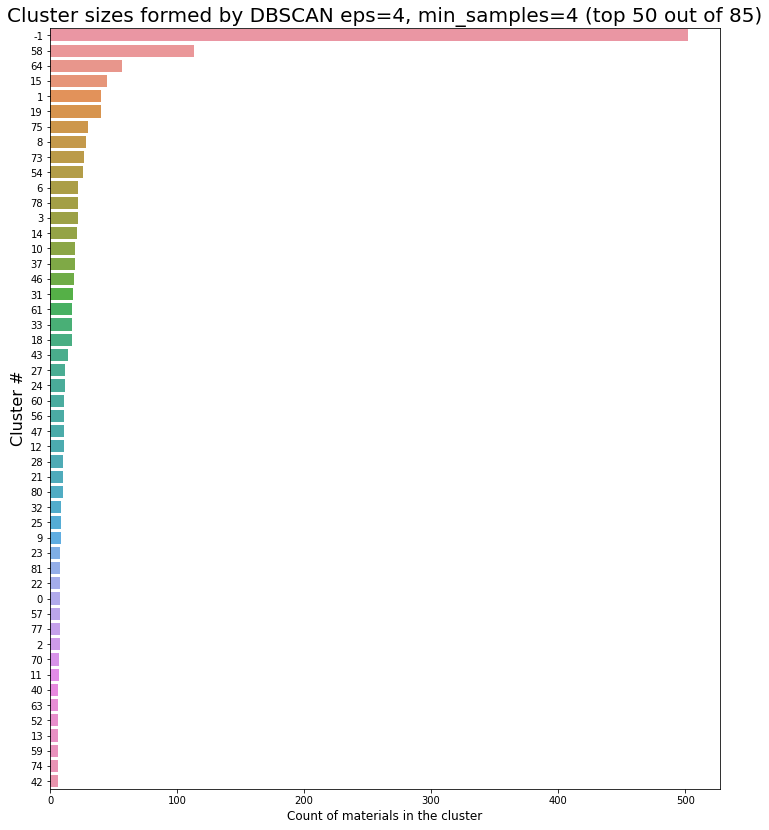

In [34]:
plt.figure(figsize=(12,14))
sort_order = materials.groupby("cluster_dbscan1")["id"].count().sort_values(ascending=False).iloc[:50].index

plt.rcParams.update({'font.size': 10})


cp = sns.countplot(data=materials, y="cluster_dbscan1", order=sort_order)
cp.set_title("Cluster sizes formed by DBSCAN eps=4, min_samples=4 (top 50 out of 85)", fontsize=20);
cp.set_xlabel("Count of materials in the cluster", fontsize=12);
cp.set_ylabel("Cluster #", fontsize=16);



DBScan identifies too many outliers. For best silhouette score the  outlier count is 502 and biggest cluster count is 113

### Materials Without Properties

Since properties has many missing columns we try to see if using the dataset without properties gives better reuslts.

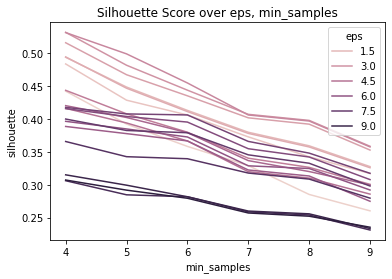

In [35]:
# Call DBScan for various EPS and min_sample values for Materials
scores2_dbscan_df = fit_loop_dbscan(X2_sc)


We get slightly better silhoette score than kmeans for DBScan. Let's look at the biggest cluster sizes. 

In [36]:
# Look for a model with a high silhouette score and the lowest outlier_count, biggest_cluster_count, cluster_std_dev 
scores2_dbscan_df[scores2_dbscan_df['outlier_count'] + scores2_dbscan_df['biggest_cluster_count'] <= 700].sort_values(['silhouette'], ascending=False)


,eps,min_samples,silhouette,cluster_count,outlier_count,biggest_cluster_count,cluster_std_dev
30,3.0,4,0.531687,78,405,294,21.889701
36,3.5,4,0.531317,76,386,294,21.294360


In [37]:
labels, silhouette = fit_dbscan(X2_sc, 3.5, 4)
silhouette

0.5313172759105806

In [38]:
# attach predicted cluster to original points
materials2_dm['cluster_dbscan'] = labels
materials2_dm['cluster_dbscan'].value_counts()

-1     386
 8     294
 26     69
 0      54
 16     45
      ... 
 10      4
 62      4
 61      4
 59      4
 38      4
Name: cluster_dbscan, Length: 76, dtype: int64

We get slightly better silhoette score than kmeans for DB Scan. However i is still lower than 0.5. Let's look at the biggest cluster sizes. 

## Hierarchical Clustering

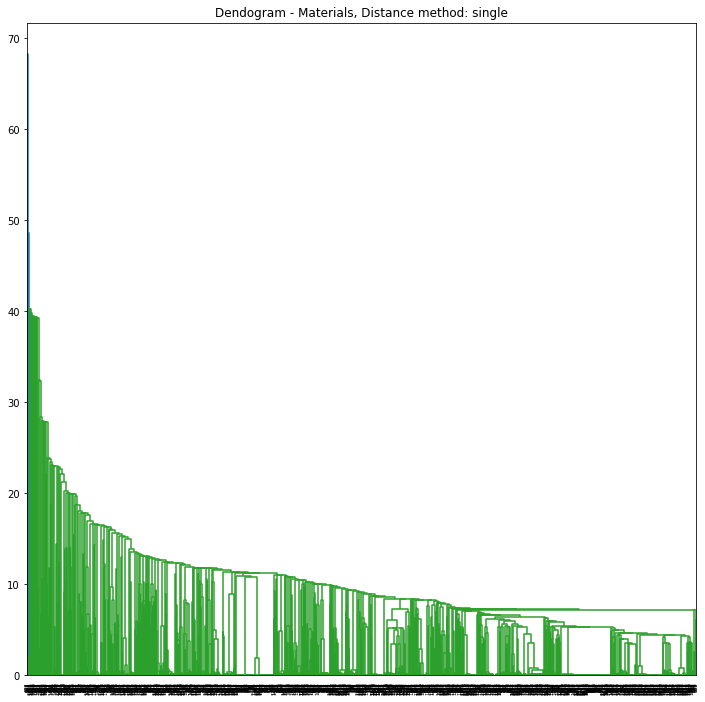

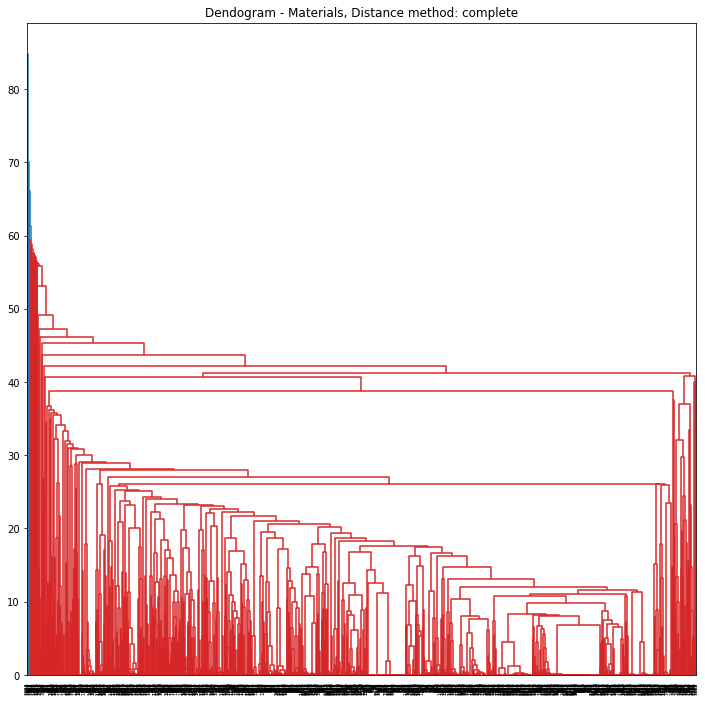

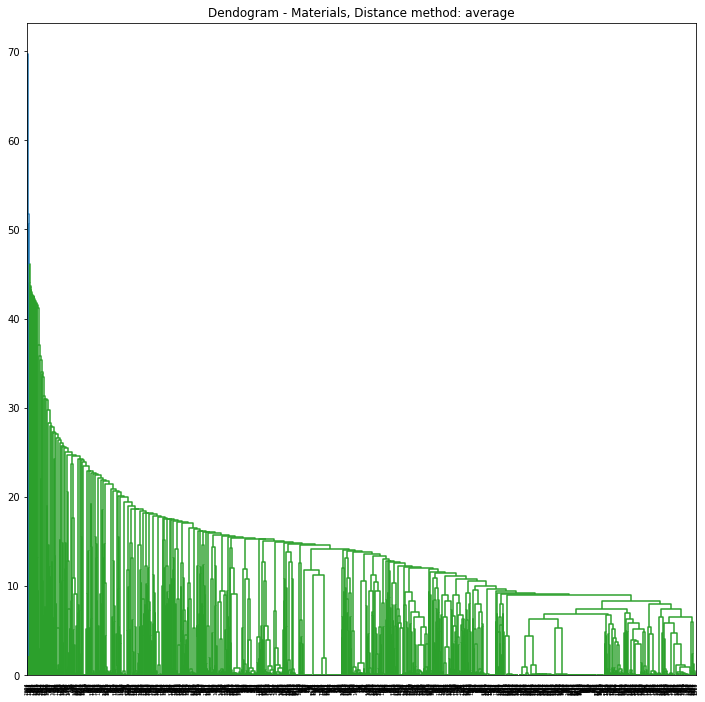

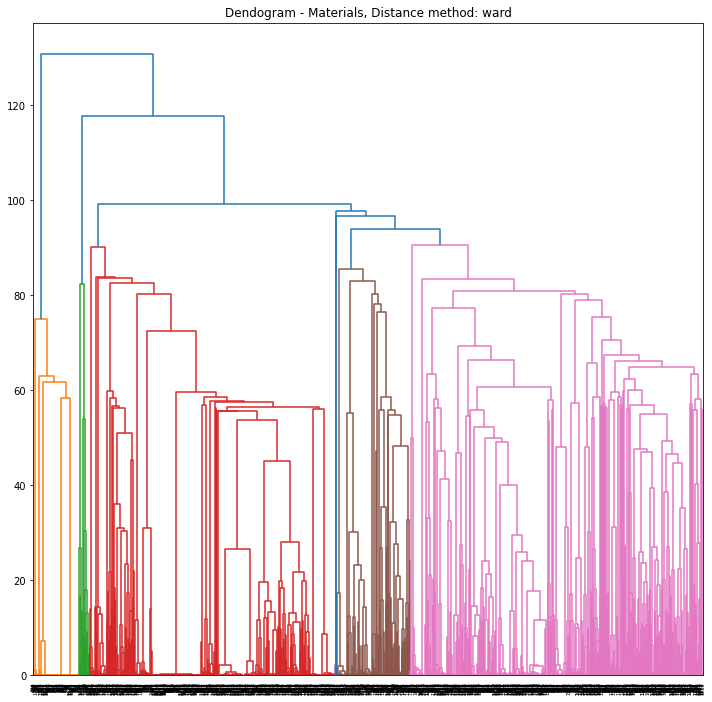

In [39]:
distance_methods = ['single', 'complete', 'average', 'ward']

# Plot dendrograms for various distance methods 
def plot_dendrograms(dataset, dataset_name, distance_methods):
    for method in distance_methods:
        plt.figure(figsize=(12, 12))
        plt.title(f"Dendogram - {dataset_name}, Distance method: {method}")
        dend = shc.dendrogram(shc.linkage(dataset, method=method), leaf_rotation=90.)
        plt.show();
    return

plot_dendrograms(X1_sc, 'Materials', distance_methods)


The dendrogram for Ward does the best in separating clusters. However we see a very big cluster on the right. The clusters still seem uneven. Let's find the custers using the 'ward' method

In [40]:
# Fit hierarchical clustering using SkLearn method
def fit_list_agglomerative(fit_dataset, distance_threshold_list, distance_method_list, label_dataset):
    for i in range(0, len(distance_threshold_list)):
        cluster1 = AgglomerativeClustering(distance_threshold=distance_threshold_list[i] ,n_clusters=None, affinity='euclidean', linkage=distance_method_list[i])
        cluster1.fit_predict(fit_dataset)

        cluster_label_name = f'hier_cluster_ {str(distance_method_list[i])}_{distance_threshold_list[i]}'
        label_dataset[cluster_label_name] = cluster1.labels_
    return 


In [41]:
#  Fit hierarchical clustering using SciPy method for a list of thresholds and distance methods
# append labels in the given dataset to indicat the cluster.
def fit_list_linkage(fit_dataset, distance_threshold_list, distance_method_list):
    scores = []
    for i in range(0, len(distance_threshold_list)):        
        labels, coph_index, silhouette_sc, cal_harab_score, len_unique_labels, max_cluster_count, std_dev_clusters = fit_linkage(fit_dataset, distance_threshold_list[i], distance_method_list[i])
   
        scores.append([distance_method_list[i], distance_threshold_list[i], coph_index, silhouette_sc, cal_harab_score, len_unique_labels, max_cluster_count, std_dev_clusters])
        
    df_scores = pd.DataFrame(scores, columns=["distance_method", "distance_threshold", "cophenet_score", "silhouette_sc", "calinski_harabasz_score", "cluster_count", "max_cluster_size", "std_dev"])
    return df_scores


In [42]:
#  Fit hierarchical clustering using SciPy method, append labels in the given dataset to indicat the cluster.
def fit_linkage(fit_dataset, distance_threshold, distance_method, label_dataset=None, level=0):
        Z = linkage(fit_dataset, distance_method)
        coph_index, coph_dists = cophenet(Z, pdist(fit_dataset))

        cluster_label_name = f'hier_cluster_{level}_{str(distance_method)}_{distance_threshold}'

        # Fcluster here
        labels = fcluster(Z, distance_threshold, criterion='distance')
        
        if (label_dataset is not None):
            label_dataset[cluster_label_name] = labels
            #print(f"cluster_label_name {label_dataset}")
 
        # Calculate metrics
        silhouette_sc = silhouette_score(fit_dataset, labels)
        cal_harab_score = calinski_harabasz_score(fit_dataset, labels)
        
        # Analyse clusters
        unique_labels, unique_labels_counts  = np.unique(labels, return_counts=True)
        max_cluster_count = unique_labels_counts[np.argmax(unique_labels_counts)]
        std_dev_clusters = np.std(labels)
       
        return labels, coph_index, silhouette_sc, cal_harab_score, len(unique_labels), max_cluster_count, std_dev_clusters


In [43]:
# Threshold 70 gives clearest bit for smaller clusters we try lower thresholds. 
distance_methods_1 = ['ward', 'ward', 'ward', 'ward', 'ward', 'ward']
distance_thresholds_1 = [8, 10, 12, 14, 16, 70]
fit_list_linkage(X1_sc, distance_thresholds_1, distance_methods_1)


,distance_method,distance_threshold,cophenet_score,silhouette_sc,calinski_harabasz_score,cluster_count,max_cluster_size,std_dev
0,ward,8,0.255592,0.736493,296.702318,362,113,97.145252
1,ward,10,0.255592,0.721769,213.950123,311,113,82.282578
2,ward,12,0.255592,0.700973,170.736074,272,113,71.099848
3,ward,14,0.255592,0.681651,140.861295,231,113,61.526271
4,ward,16,0.255592,0.670703,129.885124,213,113,56.002060
5,ward,70,0.255592,0.179796,32.066877,28,421,7.491897


In [44]:
materials.head()

,id,created_at,updated_at,code,fabric_weave,currency,supplier_id,price,name,fabric_blend_one,...,properties,only_for_brands,end_use,supp_name,supp_fabric_type,supp_specialty,supp_end_uses,supp_fibers,cluster_km,cluster_dbscan1
0,2253,2021-04-13 14:32:14.096000+00:00,2021-07-28 08:59:59.993000+00:00,C201069,Ripstop,EUR,23,11.90,XXXXXXXXXXganic Cotton,Organic Cotton,...,[],[],"['Coat', 'Jacket', 'Pants']",XXXXXXXXXX,TECHNICAL AND OUTWEAR FABRICS,blank_specialty,MEDIUM HIGH LUXURY BRANDS,"Cotton, Polyamide (Nylon) ,Polyester, Wool, SE,LI",42,0
1,557,2020-01-30 10:24:36.482000+00:00,2021-06-18 04:11:19.866000+00:00,Checkered Stripes,blank_weave,USD,25,13.52,XXXXXXXXXXStripes TENCEL,TENCEL Lyocell,...,[],[],"['Dress', 'Pants', 'Skirt']",XXXXXXXXXX,blank_fabrictype,"Wovens, small order",blank_end_uses,blank_fibers,26,-1
2,947,2020-06-04 14:11:02.191000+00:00,2021-05-11 12:31:46.481000+00:00,Low MOQ Sr 11,Plain,USD,27,1.80,XXXXXXXXXXtton (40sx40s/136x70),Organic Cotton,...,[],[],['Shirt'],XXXXXXXXXXics,Woven and Knits,blank_specialty,"Mens Wear, Women's wear, OOTD",Organic natural fibres,18,1
3,2276,2021-04-30 09:47:50.602000+00:00,2021-07-29 15:00:06.378000+00:00,CIAO/ORG,Terry,EUR,44,15.90,XXXXXXXXXXerry Organic Cotton,Organic Cotton,...,[],[],"['Sweatshirt', 'Leggings / Yoga Pants', 'Blous...",XXXXXXXXXX,Knit,Recycled Natural Fibre,blank_end_uses,"Recycled Wool, Recycled Cotton",18,-1
4,1840,2020-12-09 15:16:21.547000+00:00,2021-06-19 04:39:06.515000+00:00,#0014BK11B0000,blank_weave,USD,67,32.00,XXXXXXXXXX0000,Recycled Cow Leather,...,[],['Archive'],"['Bags & Wallets', 'Shoes']",XXXXXXXXXXher,Others,Sustainable Leather,"Accessories, Leather Goods, Luxury, New Innova...",Leather / Skin,25,2


In [45]:
# Perform Hierarchical clustering with the distance threshold that has the highest silhoette score 

labels, coph_index, silhouette_sc, cal_harab_score, len_unique_labels, max_cluster_count, std_dev_clusters =  fit_linkage(X1_sc, 
                                                                      8, 'ward', materials)
print(f'''Cophenet Index: {coph_index},\nSilhouette Score: {silhouette_sc},\nCalinski Harabasz Score:{cal_harab_score},\nUnique Labels Count: {len_unique_labels},\nMax Cluster Size: {max_cluster_count},\nStandard Dev. in Cluster Size: {std_dev_clusters}\n''')


Cophenet Index: 0.2555923102794333,
Silhouette Score: 0.7364925144359205,
Calinski Harabasz Score:296.70231810917556,
Unique Labels Count: 362,
Max Cluster Size: 113,
Standard Dev. in Cluster Size: 97.14525199482682



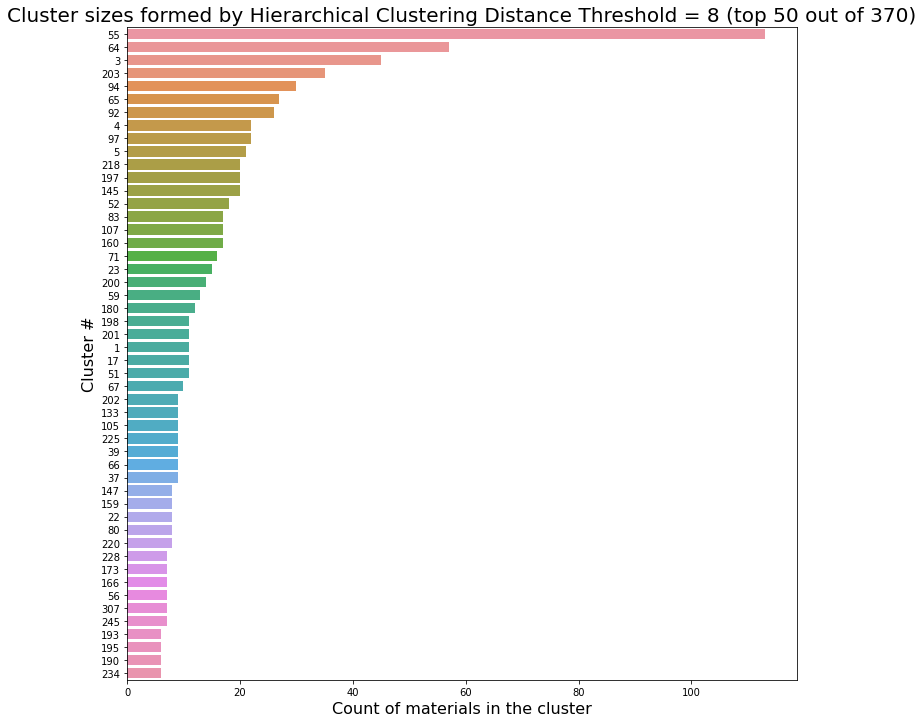

In [46]:
plt.figure(figsize=(12,12))
sort_order = materials.groupby("hier_cluster_0_ward_8")["id"].count().sort_values(ascending=False).iloc[:50].index

cp = sns.countplot(data=materials, y="hier_cluster_0_ward_8", order=sort_order)
cp.set_title("Cluster sizes formed by Hierarchical Clustering Distance Threshold = 8 (top 50 out of 370)", fontsize=20);
cp.set_xlabel("Count of materials in the cluster", fontsize=16);
cp.set_ylabel("Cluster #", fontsize=16);


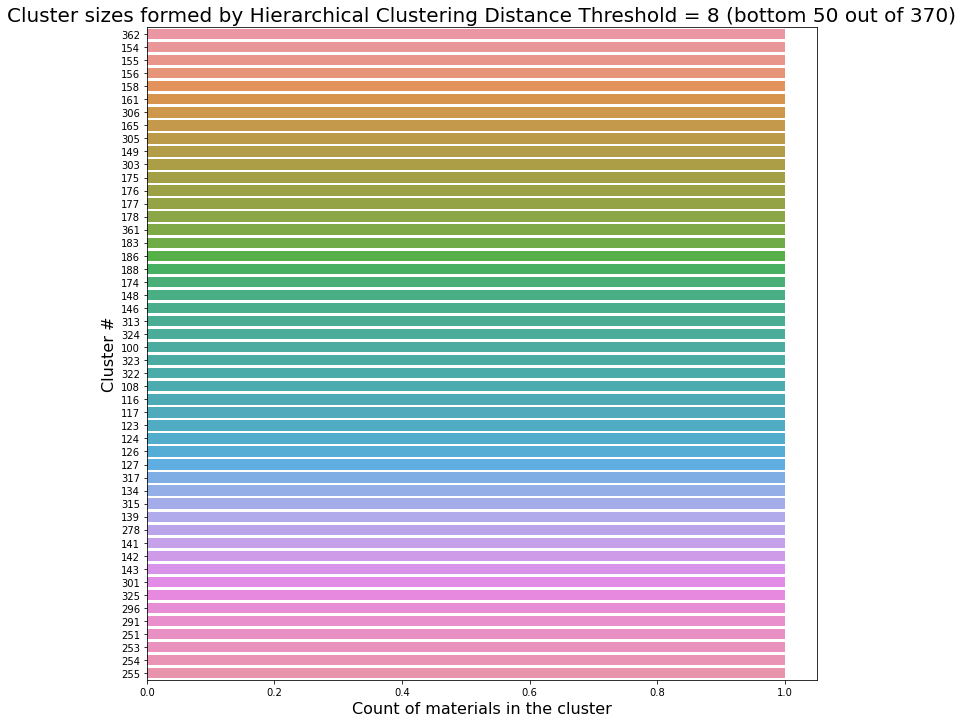

In [47]:
plt.figure(figsize=(12,12))
sort_order = materials.groupby("hier_cluster_0_ward_8")["id"].count().sort_values(ascending=True).iloc[:50].index

cp = sns.countplot(data=materials, y="hier_cluster_0_ward_8", order=sort_order)
cp.set_title("Cluster sizes formed by Hierarchical Clustering Distance Threshold = 8 (bottom 50 out of 370)", fontsize=20);
cp.set_xlabel("Count of materials in the cluster", fontsize=16);
cp.set_ylabel("Cluster #", fontsize=16);



Cluster sizes vary from 113 to 1. More than 50 clusters have cluster size of 1. For materials in big clusters, it will be difficult to find the best matching recommendations. For cluster sizes below 5, we can't give sufficient recommendations. 

In [48]:
# Perform Hierarchical clustering with distance threshold=70 to get bigger clusters
# we will try to get recommendtaions based in the clusters. 

labels, coph_index, silhouette_sc, cal_harab_score, len_unique_labels, max_cluster_count, std_dev_clusters =  fit_linkage(X1_sc, 
                                                                      70, 'ward', materials)
print(f'''Cophenet Index: {coph_index},\nSilhouette Score: {silhouette_sc},\nCalinski Harabasz Score:{cal_harab_score},\nUnique Labels Count: {len_unique_labels},\nMax Cluster Size: {max_cluster_count},\nStandard Dev. in Cluster Size: {std_dev_clusters}\n''')


Cophenet Index: 0.2555923102794333,
Silhouette Score: 0.1797959355585518,
Calinski Harabasz Score:32.06687668744839,
Unique Labels Count: 28,
Max Cluster Size: 421,
Standard Dev. in Cluster Size: 7.4918972288329355



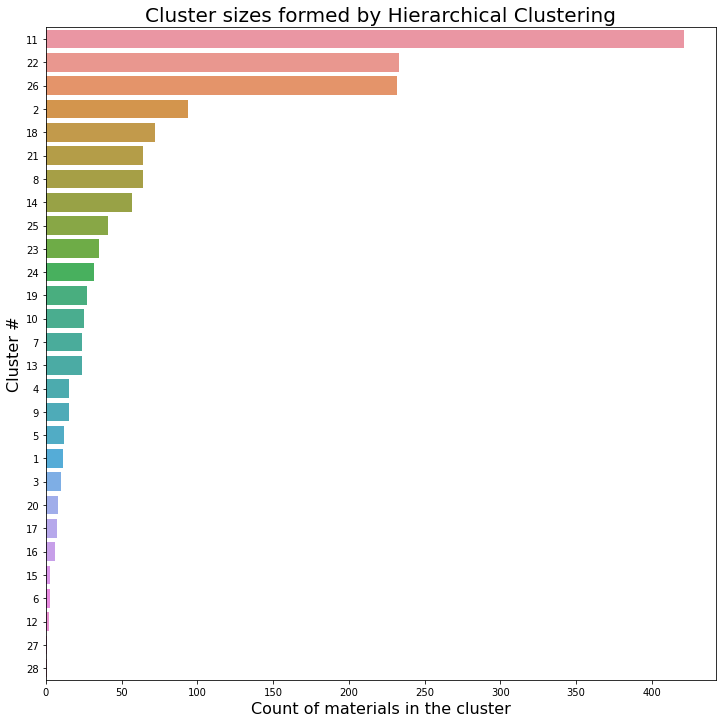

In [49]:
plt.figure(figsize=(12,12))
sort_order = materials.groupby("hier_cluster_0_ward_70")["id"].count().sort_values(ascending=False).index.values

cp = sns.countplot(data=materials, y="hier_cluster_0_ward_70", order=sort_order)
cp.set_title("Cluster sizes formed by Hierarchical Clustering", fontsize=20);
cp.set_xlabel("Count of materials in the cluster", fontsize=16);
cp.set_ylabel("Cluster #", fontsize=16);

## Materials Without Properties

Since properties has many missing columns we try to see if using the dataset without properties gives better reuslts.

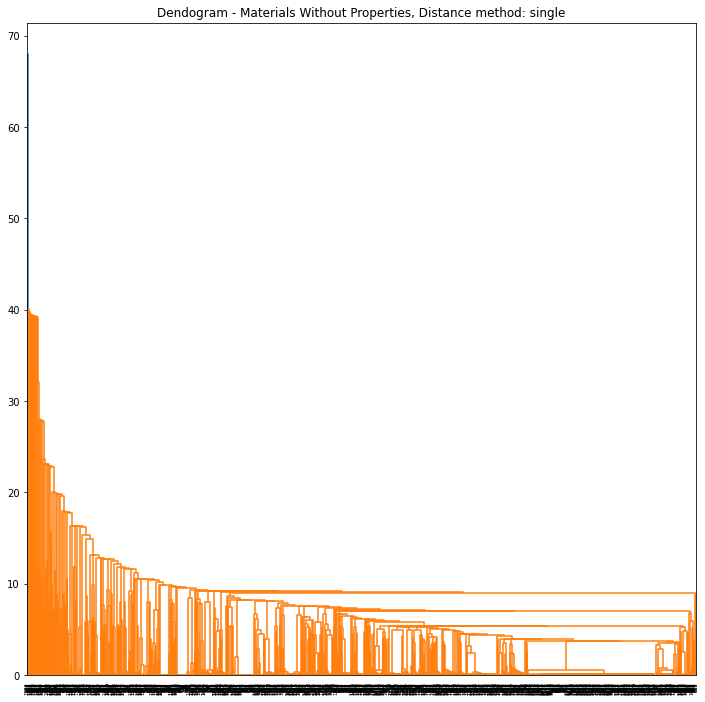

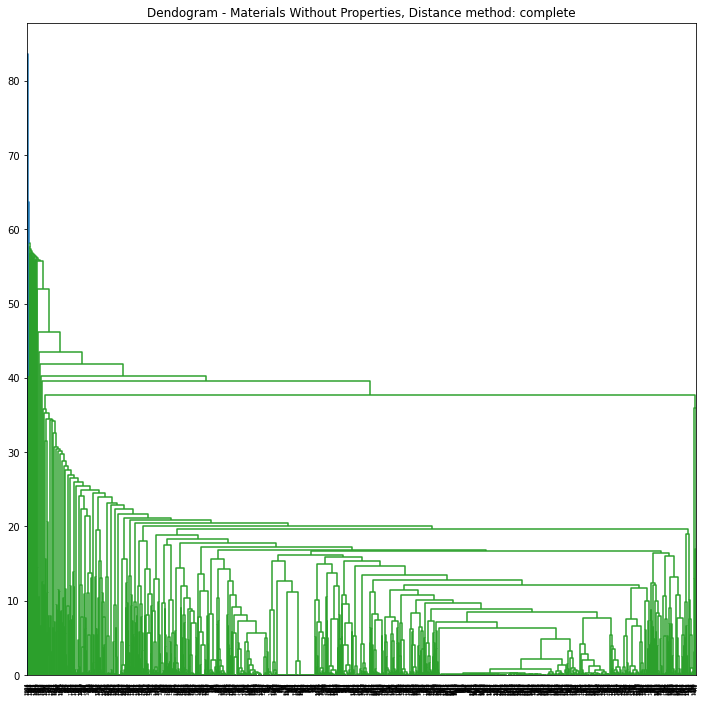

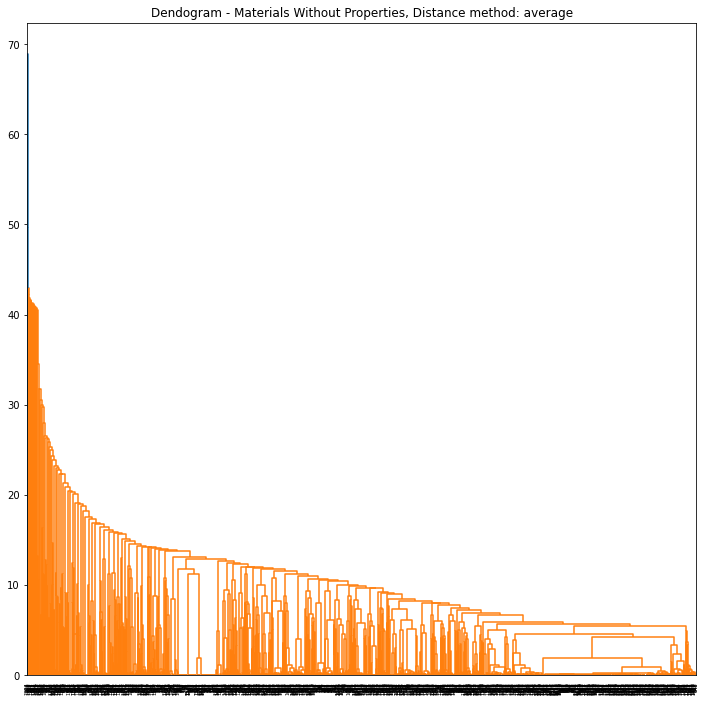

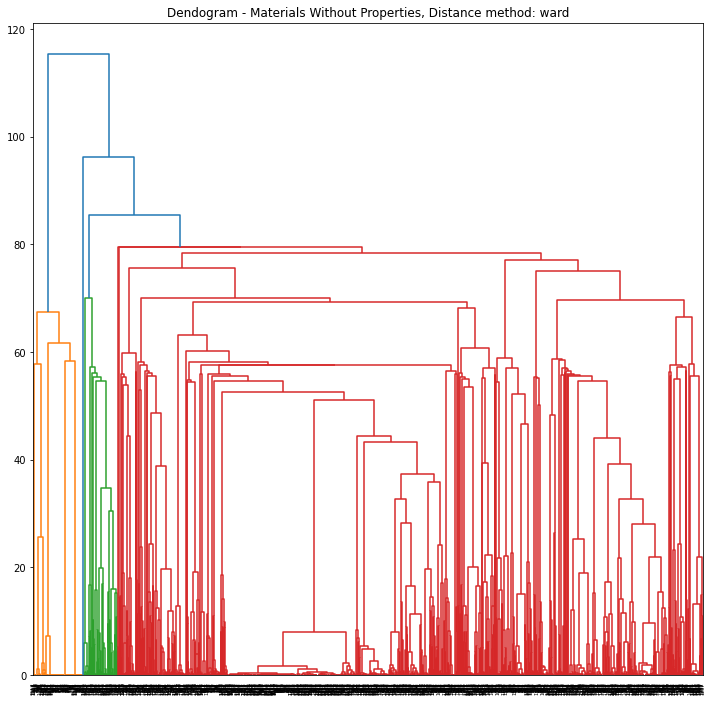

In [50]:
plot_dendrograms(X2_sc, 'Materials Without Properties', distance_methods)

In [51]:
distance_methods_2 = ['single', 'complete', 'average', 'ward', 'ward', 'ward', 'ward', 'ward', 'ward', 'weighted', 'centroid', 'median']
distance_thresholds_2 = [6, 8, 6, 14, 16, 18, 20, 22, 70, 8, 8, 7]

fit_list_linkage(X2_sc, distance_thresholds_2, distance_methods_2)


,distance_method,distance_threshold,cophenet_score,silhouette_sc,calinski_harabasz_score,cluster_count,max_cluster_size,std_dev
0,single,6,0.969834,0.471192,59.584871,189,741,37.155460
1,complete,8,0.948685,0.615418,152.998531,196,333,38.818394
2,average,6,0.980821,0.587447,128.658097,233,492,54.527967
3,ward,14,0.368030,0.704343,191.884974,160,294,42.357142
4,ward,16,0.368030,0.686388,173.762261,142,294,37.656824
5,ward,18,0.368030,0.669432,160.747522,128,294,33.393715
6,ward,20,0.368030,0.644874,151.052384,118,294,30.425860
7,ward,22,0.368030,0.631498,145.096834,113,294,29.328466
8,ward,70,0.368030,0.136029,35.527199,11,737,2.528548
9,weighted,8,0.969357,0.560705,116.670497,178,455,38.970986


In [52]:
# Perform Hierarchical clustering with the best method and distance threshold for X2_sc
labels, coph_index, silhouette_sc, cal_harab_score, len_unique_labels, max_cluster_count, std_dev_clusters =  fit_linkage(X2_sc, 
                                                                      70, 'ward', materials2_dm)
print(f'''Cophenet Index: {coph_index},\nSilhouette Score: {silhouette_sc},\nCalinski Harabasz Score:{cal_harab_score},\nUnique Labels Count: {len_unique_labels},\nMax Cluster Size: {max_cluster_count},\nStandard Dev. in Cluster Size: {std_dev_clusters}\n''')


Cophenet Index: 0.3680300158683767,
Silhouette Score: 0.13602936748831151,
Calinski Harabasz Score:35.5271993146721,
Unique Labels Count: 11,
Max Cluster Size: 737,
Standard Dev. in Cluster Size: 2.5285483961939392



In [53]:
materials2_dm['hier_cluster_0_ward_70'].value_counts()

7     737
10    353
1     115
8      87
6      87
2      79
5      39
9      36
4       3
3       2
11      1
Name: hier_cluster_0_ward_70, dtype: int64

## Dimensionality Reduction - PCA

We will now try to use PCA and perform Dimensionality Reduction visualise the clusters. We reduce to 3 dimensions and plot the datapoints.

### Materials

In [54]:
# Instantiate PCA.
pca1 = PCA(random_state = 123)

In [55]:
# Fit PCA on the the scaled materials dataset.
principalComponents1 = pca1.fit_transform(X1_sc)

In [56]:
df_pca_components1 = pd.DataFrame(principalComponents1, df_X1_sc.index)
df_pca_components1

materials_dm['pca-one'] = principalComponents1[:, 0]
materials_dm['pca-two'] = principalComponents1[:, 1]
materials_dm['pca-three'] = principalComponents1[:, 2]

In [57]:
# Pull the explained variance attribute.
var_exp = pca1.explained_variance_ratio_
print(f'Explained variance (first 60 components): {np.round(var_exp[:60],3)}')

# Generate the cumulative explained variance.
cum_var_exp = np.cumsum(var_exp)
print(f'Cumulative explained variance (first 60 components): {np.round(cum_var_exp[:60],3)}')

Explained variance (first 60 components): [0.035 0.031 0.023 0.022 0.02  0.02  0.018 0.017 0.017 0.016 0.016 0.015
 0.014 0.014 0.013 0.013 0.013 0.012 0.012 0.012 0.012 0.011 0.011 0.011
 0.011 0.011 0.01  0.01  0.01  0.01  0.01  0.009 0.009 0.008 0.008 0.008
 0.008 0.008 0.007 0.007 0.007 0.007 0.007 0.007 0.007 0.007 0.007 0.006
 0.006 0.006 0.006 0.006 0.006 0.006 0.006 0.006 0.006 0.006 0.006 0.006]
Cumulative explained variance (first 60 components): [0.035 0.066 0.088 0.11  0.13  0.15  0.167 0.184 0.201 0.217 0.233 0.247
 0.262 0.275 0.288 0.301 0.314 0.326 0.338 0.35  0.362 0.373 0.384 0.395
 0.407 0.417 0.427 0.437 0.447 0.457 0.467 0.476 0.485 0.494 0.502 0.51
 0.518 0.526 0.533 0.54  0.547 0.554 0.561 0.568 0.574 0.581 0.587 0.594
 0.6   0.606 0.613 0.619 0.625 0.631 0.637 0.643 0.649 0.655 0.661 0.666]


[Text(0, 0.5, 'PCA3')]

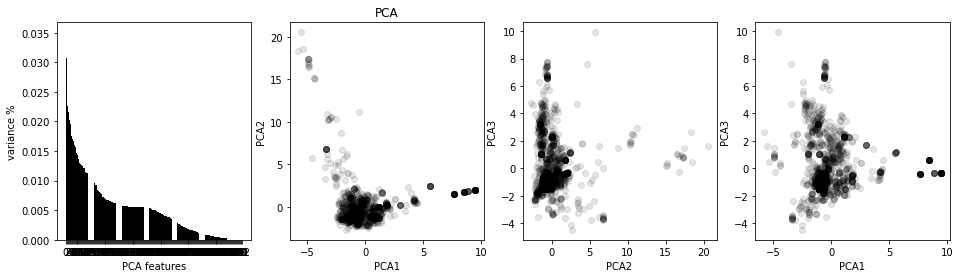

In [58]:
# Plot the explained variances
features = range(pca1.n_components_)

fig,ax = plt.subplots(1,4, figsize=(16,4))

ax[0].bar(features, pca1.explained_variance_ratio_, color='black')
ax[0].set(xlabel = 'PCA features')
ax[0].set(ylabel = 'variance %')
ax[0].set(xticks = features)

ax[1].scatter(df_pca_components1[0], df_pca_components1[1], alpha=.1, color='black')
ax[1].set(xlabel = 'PCA1')
ax[1].set(ylabel = 'PCA2')
ax[1].set(title='PCA')

ax[2].scatter(df_pca_components1[1], df_pca_components1[2], alpha=.1, color='black')
ax[2].set(xlabel = 'PCA2')
ax[2].set(ylabel = 'PCA3')

ax[3].scatter(df_pca_components1[0], df_pca_components1[2], alpha=.1, color='black')
ax[3].set(xlabel = 'PCA1')
ax[3].set(ylabel = 'PCA3')

The visialisations show that data points are not visually separated into clusters. 

In [59]:
df_pca_components1.loc[:, : 1]

,0,1
0,0.505417,0.074186
1,0.979887,-1.121636
2,-0.604514,-1.115908
3,-0.931376,-1.637084
4,3.017493,0.206768
...,...,...
1534,8.857759,1.851486
1535,9.431974,1.984069
1536,1.438140,1.773600
1537,1.200902,2.162844


### Materials with properties

Since properties has many missing columns we try to see if using the dataset without properties gives better reuslts.

In [60]:
pca2 = PCA(random_state = 123)

In [61]:
principalComponents2 = pca2.fit_transform(X2_sc)

In [62]:
df_pca_components2 = pd.DataFrame(principalComponents2, df_X2_sc.index)
df_pca_components2

materials2_dm['pca-one'] = principalComponents2[:, 0]
materials2_dm['pca-two'] = principalComponents2[:, 1]
materials2_dm['pca-three'] = principalComponents2[:, 2]

In [63]:
# Pull the explained variance attribute.
var_exp = pca2.explained_variance_ratio_
print(f'Explained variance (first 60 components): {np.round(var_exp[:60],3)}')

print('')

# Generate the cumulative explained variance.
cum_var_exp = np.cumsum(var_exp)
print(f'Cumulative explained variance (first 60 components): {np.round(cum_var_exp[:60],3)}')

Explained variance (first 60 components): [0.044 0.027 0.026 0.025 0.023 0.021 0.019 0.018 0.017 0.017 0.016 0.016
 0.015 0.015 0.014 0.013 0.013 0.013 0.012 0.012 0.011 0.011 0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.009 0.009 0.009 0.009 0.009 0.009
 0.009 0.009 0.009 0.008 0.008 0.008 0.008 0.008 0.008 0.008 0.008 0.008
 0.008 0.008 0.008 0.008 0.008 0.008 0.008 0.008 0.008 0.008 0.008 0.008]

Cumulative explained variance (first 60 components): [0.044 0.071 0.097 0.122 0.145 0.165 0.184 0.201 0.219 0.236 0.252 0.268
 0.283 0.297 0.312 0.325 0.338 0.351 0.362 0.374 0.385 0.396 0.407 0.417
 0.427 0.437 0.447 0.457 0.467 0.476 0.486 0.495 0.504 0.513 0.522 0.531
 0.539 0.548 0.557 0.565 0.573 0.582 0.59  0.599 0.607 0.615 0.624 0.632
 0.64  0.648 0.657 0.665 0.673 0.681 0.69  0.698 0.706 0.714 0.723 0.731]


[Text(0, 0.5, 'PCA3')]

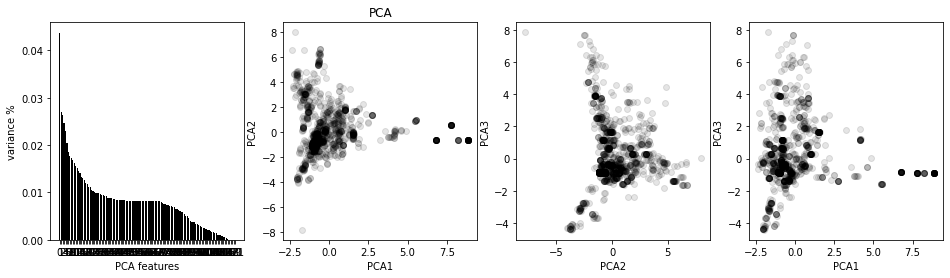

In [64]:
# Plot the explained variances
features = range(pca2.n_components_)

fig,ax = plt.subplots(1,4, figsize=(16,4))

ax[0].bar(features, pca2.explained_variance_ratio_, color='black')
ax[0].set(xlabel = 'PCA features')
ax[0].set(ylabel = 'variance %')
ax[0].set(xticks = features)

ax[1].scatter(df_pca_components2[0], df_pca_components2[1], alpha=.1, color='black')
ax[1].set(xlabel = 'PCA1')
ax[1].set(ylabel = 'PCA2')
ax[1].set(title='PCA')

ax[2].scatter(df_pca_components2[1], df_pca_components2[2], alpha=.1, color='black')
ax[2].set(xlabel = 'PCA2')
ax[2].set(ylabel = 'PCA3')

ax[3].scatter(df_pca_components2[0], df_pca_components2[2], alpha=.1, color='black')
ax[3].set(xlabel = 'PCA1')
ax[3].set(ylabel = 'PCA3')

## TSNE

t-SNE is a statistical method for visualizing high-dimensional data by giving each datapoint a location in a two or three-dimensional map. It models each high-dimensional object by a two- or three-dimensional point in such a way that similar objects are modeled by nearby points and dissimilar objects are modeled by distant points. We reduce to 3 dimensions and plot the datapoints.

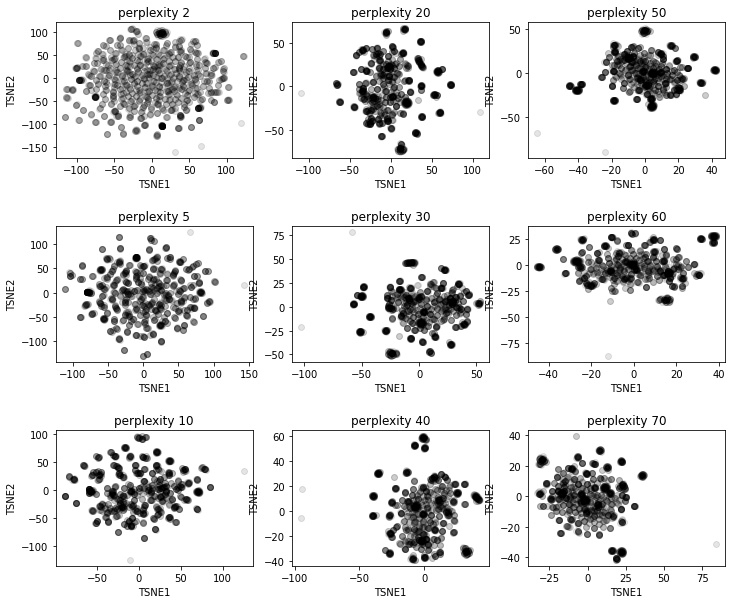

In [65]:
# Run TSNE to reduce data to 2 dimensions over various perplexity parameters and plot it

from sklearn.manifold import TSNE #T-Distributed Stochastic Neighbor Embedding

ps = [2, 5,10,20,30,40,50,60,70]

fig,ax = plt.subplots(3, 3, figsize=(12,10))
plt.subplots_adjust(hspace=.5)
import math 

# the search for ideal perplexity hyperameters...
for i, perplexity in enumerate(ps):
    tsne = TSNE(n_components=2, perplexity=perplexity)
    tsneComponents = tsne.fit_transform(df_X1_sc)
    TSNE_components = pd.DataFrame(tsneComponents, index=df_X1_sc.index)

    ax[i%3][math.floor(i/3)].set_title(f'perplexity {perplexity}')
    ax[i%3][math.floor(i/3)].scatter(TSNE_components[0], TSNE_components[1], alpha=.1, color='black')
    ax[i%3][math.floor(i/3)].set(xlabel = 'TSNE1')
    ax[i%3][math.floor(i/3)].set(ylabel = 'TSNE2')


In [66]:
# pick perp 2, comps 2
tsne = TSNE(n_components=2, perplexity=2)
tsneComponents = tsne.fit_transform(df_X1_sc)
TSNE_components = pd.DataFrame(tsneComponents, index=df_X1_sc.index)
TSNE_components.head()


,0,1
0,-21.611113,-4.233324
1,-73.447350,-36.021488
2,-8.962413,-48.312904
3,46.523392,51.447289
4,-38.263748,106.936676


#### Kmeans with TSNE

The plots above don't show separable clusters. We perform kmeans clustering with reduced dimensions to see the clusters that are formed.

In [67]:
from random import randint


def plot_clusters(cluster_name, cluster_cases, df_comp, dims=2):
    fig,ax = plt.subplots(1,len(cluster_cases), figsize=(16,4))

    for c,clusters in enumerate(cluster_cases):
        model = KMeans(n_clusters=clusters)
        df_comp2 = df_comp.copy()
        m = model.fit(df_comp2)
        df_comp2.insert(0, 'cluster', m.labels_)
      
        datas = []
        colors = []

        for i in range(clusters): 
            tup = []
            for j in range(dims):  ## should be cluster dims? pca dims?
                tup.append(df_comp2[df_comp2['cluster']==i][j])
            datas.append(tup)
            colors.append('#%06X' % randint(0, 0xFFFFFF))
        
        groups = [cluster_name+str(i) for i in range(clusters)]
        #colors = ('green','red','blue','yellow','purple','brown')
            

        for data,color,group in zip(datas,colors,groups):
            x,y = data[0],data[1]
            ax[c].scatter(x, y, alpha=0.5, c=color, edgecolors='none', s=100, label=group)
            ax[c].set_title(f'{cluster_name} Kmeans {clusters} clusters')
            ax[c].set(xlabel=cluster_name+'1')
            ax[c].set(ylabel=cluster_name+'2')
    plt.show()

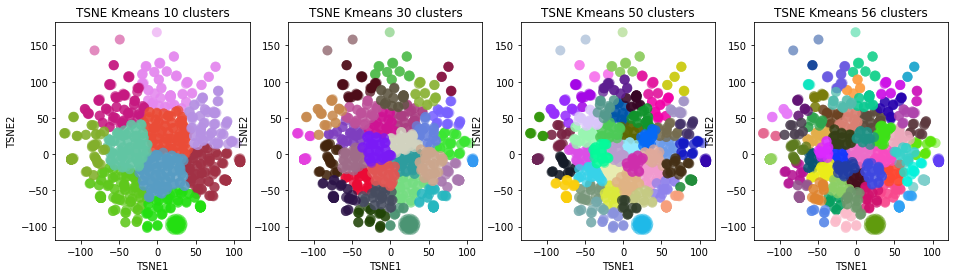

In [68]:
cluster_cases = [10, 30 , 50, 56]
plot_clusters('TSNE', cluster_cases, TSNE_components)


Although clusters are shown we see that the clusters are very close togeher and not very easily separable. This is an indication of bad case of clustering.  

#### DBSCAN with TSNE

Try the DBSCAN algorithm with various values of sample size and eps

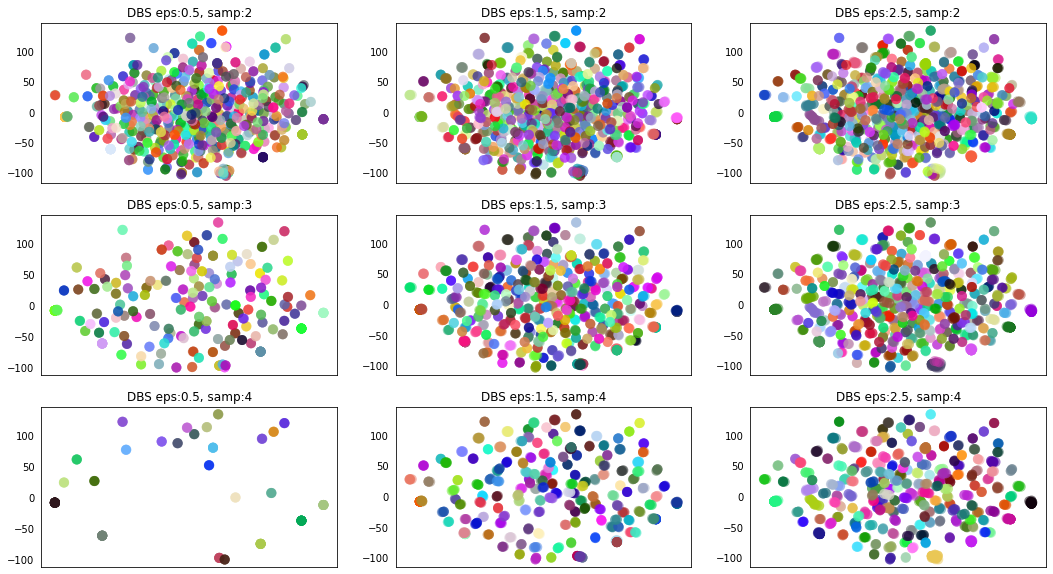

In [69]:
import numpy as np
from itertools import product
from math import floor  

samp_list = [2,3,4]
eps_list = [0.5, 1.5, 2.5]
rows = len(samp_list)

fig, ax = plt.subplots(len(samp_list), len(eps_list), figsize=(18,10))

for k, (eps, samp) in enumerate(product(eps_list, samp_list)):
    ax[k%rows][floor(k/rows)].tick_params(axis='both',which='both',bottom=False,top=False,left=False,labelbottom=False) 

    TSNE_df = TSNE_components.copy()
    clustering = DBSCAN(eps=eps, min_samples=samp).fit(TSNE_df)
    TSNE_df.insert(0, 'cluster', clustering.labels_)

    datas = [[TSNE_df[TSNE_df['cluster']==i][j] for j in range(2)] for i in range(len(set(clustering.labels_)))]
    #colors = ('green','red','blue','yellow','purple','brown','orange','purple')
    colors = []
    for i in range(len(set(clustering.labels_))): 
        colors.append('#%06X' % randint(0, 0xFFFFFF))
    
    groups = [str(i) for i in range(len(set(clustering.labels_)))]

    for data,color,group in zip(datas,colors,groups):
        ax[k%rows][floor(k/rows)].scatter(data[0],data[1], alpha=0.5, c=color, edgecolors='none', s=100, label=group)
        ax[k%rows][floor(k/rows)].set_title(f'DBS eps:{eps}, samp:{samp}')

Although clusters are shown we see that the clusters are interspersed togeher and not very easily separable. This is an indication of bad case of clustering.  

**Conclusion for clustering**: By seeing various methods of clusterin we conclude that materials data is naturally not separated in clusters. This could be becuase in terms of the significant features, many materials have more or less similar values. We conclude that clustering is not the best method for getting recommendations in our case. We will proceed to see the other method below. In addition, we will still consider using hierarchical clustering in conjunction with the next method. 

# Finding Similarity

We use pairwise similarity metrics to create a similarity matrix of all the materials with the rest of the materials. Then we find the top 10 materials with the highest similarity with the requester material. 

Following combinations will be tried:
1. First we will use the materials from a cluster formed earlier using hierarchical clustering. Here we will use pairwise similarity metrics within the cluster to find recomemndations and observe the results. Next we use pairwise similarity metrics on the whole dataset. 
2. We will use both scaled and unscaled data to see the difference.
3. We will use Cosine Simlarity and Sigmoid Kernel

In [70]:
# Find the datasets for the hierarchical cluster
df_materials_cluster1_full = materials[materials['hier_cluster_0_ward_70'] == 11]
df_materials_cluster1 = materials_dm[materials['hier_cluster_0_ward_70'] == 11]
df_materials_cluster_X1 = X1_mm[materials['hier_cluster_0_ward_70'] == 11]

In [71]:
df_materials_cluster1_full[df_materials_cluster1_full["fabric_blend_one"].str.find("Nylon") > -1]


,id,created_at,updated_at,code,fabric_weave,currency,supplier_id,price,name,fabric_blend_one,...,end_use,supp_name,supp_fabric_type,supp_specialty,supp_end_uses,supp_fibers,cluster_km,cluster_dbscan1,hier_cluster_0_ward_8,hier_cluster_0_ward_70
72,592,2020-02-12 09:40:23.675000+00:00,2021-06-18 11:33:26.171000+00:00,CY-F-WQA0321,Single Jersey,USD,19,5.84,XXXXXXXXXXsey Nylon Elastine 9,Nylon / Polyamide,...,[],XXXXXXXXXX,blank_fabrictype,blank_specialty,blank_end_uses,blank_fibers,19,27,59,11
73,604,2020-02-12 09:40:23.843000+00:00,2021-06-18 11:33:26.381000+00:00,CY-WQA0337,Single Jersey,USD,19,6.23,XXXXXXXXXXsey Nylon Elastine 1,Nylon / Polyamide,...,[],XXXXXXXXXX,blank_fabrictype,blank_specialty,blank_end_uses,blank_fibers,19,27,59,11
81,1452,2020-08-24 20:02:34.439000+00:00,2021-06-18 12:40:01.520000+00:00,BAM-P017006,blank_weave,USD,18,5.20,XXXXXXXXXXch Bamboo Nylon,Nylon / Polyamide,...,[],XXXXXXXXXXCo Ltd,Woven,"High performance, technical fabrics","Snow, Outdoor, Urban, Mountain, Workwear","Recycled Nylon, Recycled Polyester",21,28,89,11
213,620,2020-02-27 09:37:37.070000+00:00,2021-06-18 11:30:55.707000+00:00,SD84R5,Plain,USD,1,5.00,XXXXXXXXXXn / Polyamide Elastine / OP / Spandex,Nylon / Polyamide,...,[],XXXXXXXXXX,Woven,"High performance, anti-abrasion fabric","Performance, Activewear, Hard Shell Jacket, So...","Nylon, Polyester",28,41,88,11
233,1984,2021-01-29 16:43:45.786000+00:00,2021-06-18 12:49:57.402000+00:00,SP1352,Single Jersey,USD,73,26.40,XXXXXXXXXXsey Recycled Nylon Elastane,Recycled Nylon,...,[],XXXXXXXXXXot,"Knit, Jacquard, Jersey",blank_specialty,blank_end_uses,blank_fibers,21,45,57,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1471,595,2020-02-12 09:40:23.719000+00:00,2021-06-18 11:33:26.364000+00:00,CY-QBT0481,blank_weave,USD,19,6.72,XXXXXXXXXXNylon Elastine 1,Nylon / Polyamide,...,[],XXXXXXXXXX,blank_fabrictype,blank_specialty,blank_end_uses,blank_fibers,19,27,59,11
1479,1060,2020-06-06 14:33:26.100000+00:00,2020-11-09 18:05:35.966000+00:00,TO-19F144 F013HAC/02,blank_weave,USD,40,3.78,XXXXXXXXXX3HAC/02,Nylon / Polyamide,...,[],XXXXXXXXXX,blank_fabrictype,blank_specialty,blank_end_uses,blank_fibers,28,73,65,11
1481,1592,2020-09-26 05:54:32.650000+00:00,2020-11-09 18:05:36.075000+00:00,TO-16F067 FR291ACT/69,blank_weave,USD,40,4.35,XXXXXXXXXX91ACT/69,Nylon / Polyamide,...,[],XXXXXXXXXX,blank_fabrictype,blank_specialty,blank_end_uses,blank_fibers,28,73,65,11
1485,1619,2020-09-26 05:54:33.276000+00:00,2020-11-09 18:05:37.033000+00:00,TO-17F035 F431HAC/58,blank_weave,USD,40,3.26,XXXXXXXXXX1HAC/58,Nylon / Polyamide,...,[],XXXXXXXXXX,blank_fabrictype,blank_specialty,blank_end_uses,blank_fibers,28,73,65,11


In [72]:
# Calculate cosine similarity matrices for all datasets
from sklearn.metrics.pairwise import cosine_similarity

cosine_sim_cluster_1 = cosine_similarity(df_materials_cluster1, df_materials_cluster1)
cosine_sim_cluster_X1 = cosine_similarity(df_materials_cluster_X1, df_materials_cluster_X1)
cosine_sim_1 = cosine_similarity(materials_dm, materials_dm)
cosine_sim_X1 = cosine_similarity(X1_mm, X1_mm)


In [73]:
# Calculate cosine Sigmoid Kernels for all datasets
from sklearn.metrics.pairwise import sigmoid_kernel

sigmoid_kernel_cluster_1 = sigmoid_kernel(df_materials_cluster1, df_materials_cluster1)
sigmoid_kernel_cluster_X1 = sigmoid_kernel(df_materials_cluster_X1, df_materials_cluster_X1)

sigmoid_kernel_1 = sigmoid_kernel(materials_dm, materials_dm)
sigmoid_kernel_X1 = sigmoid_kernel(X1_mm, X1_mm)


In [74]:
# Create a dataset from the similarity matrices so that they can be indexed using material ids

df_cosine_sim_cluster_1 = pd.DataFrame(cosine_sim_cluster_1, index=df_materials_cluster1_full.loc[df_materials_cluster1.index]['id'], columns=df_materials_cluster1_full.loc[df_materials_cluster1.index]['id'])
df_cosine_sim_cluster_X1 = pd.DataFrame(cosine_sim_cluster_X1, index=df_materials_cluster1_full.loc[df_materials_cluster1.index]['id'], columns=df_materials_cluster1_full.loc[df_materials_cluster1.index]['id'])

df_sigmoid_kernel_cluster_1 = pd.DataFrame(sigmoid_kernel_cluster_1, index=df_materials_cluster1_full.loc[df_materials_cluster1.index]['id'], columns=df_materials_cluster1_full.loc[df_materials_cluster1.index]['id'])
df_sigmoid_kernel_cluster_X1 = pd.DataFrame(sigmoid_kernel_cluster_X1, index=df_materials_cluster1_full.loc[df_materials_cluster1.index]['id'], columns=df_materials_cluster1_full.loc[df_materials_cluster1.index]['id'])

df_cosine_sim_X1 = pd.DataFrame(cosine_sim_X1, columns=materials.loc[materials_dm.index]['id'], index=materials.loc[materials_dm.index]['id'])
df_cosine_sim_1 = pd.DataFrame(cosine_sim_1, columns=materials.loc[materials_dm.index]['id'], index=materials.loc[materials_dm.index]['id'])

df_sigmoid_kernel_1 = pd.DataFrame(sigmoid_kernel_1, columns=materials.loc[materials_dm.index]['id'], index=materials.loc[materials_dm.index]['id'])
df_sigmoid_kernel_X1 = pd.DataFrame(sigmoid_kernel_X1, columns=materials.loc[materials_dm.index]['id'], index=materials.loc[materials_dm.index]['id'])

### Cosine Similarity -  Individual cluster using Hierarchical Clustering, No Scaling

In [75]:
results, orig = get_recommendations(df_materials_cluster1_full, df_cosine_sim_cluster_1, mat_id=1983)#, full_dataset=df_materials_cluster1_full)
    
orig.loc[:, ['id','name', 'fabric_blend_one', 'price', 'weight', 'supplier_id', 'end_use', 'properties']]
    

,id,name,fabric_blend_one,price,weight,supplier_id,end_use,properties
1497,1983,XXXXXXXXXXsey Recycled Nylon Elastane,Recycled Nylon,26.5,180.0,73,[],[]


In [76]:
results.loc[:, ['id','name', 'fabric_blend_one', 'price', 'weight', 'supplier_id', 'end_use', 'properties']]


,id,name,fabric_blend_one,price,weight,supplier_id,end_use,properties
233,1984,XXXXXXXXXXsey Recycled Nylon Elastane,Recycled Nylon,26.40,180.0,73,[],[]
624,516,XXXXXXXXXXcled Nylon,Recycled Nylon,16.26,113.0,21,[],['Water Repellent (W/R)']
981,509,XXXXXXXXXXcled Nylon,Recycled Nylon,16.26,122.0,21,[],['Water Repellent (W/R)']
733,513,XXXXXXXXXXcled Nylon Viscose,Recycled Nylon,16.85,135.0,21,[],['Water Repellent (W/R)']
973,1979,XXXXXXXXXXsey Recycled Polyester Elastane,Recycled Nylon,11.90,110.0,73,[],[]
584,514,XXXXXXXXXXcled Nylon,Recycled Nylon,11.76,60.0,21,[],['Water Repellent (W/R)']
1132,1978,XXXXXXXXXXsey Recycled Polyester Elastane,Recycled Polyester,11.90,140.0,73,[],[]
386,382,XXXXXXXXXXamo Membrane Plain Nylon,Nylon / Polyamide,5.60,50.0,18,[],['Water Repellent (W/R)']
1359,632,XXXXXXXXXXPlain Recycled Nylon,Nylon / Polyamide,5.94,59.0,18,[],['Durable Water Repellent (DWR)']
1124,517,XXXXXXXXXXecycled Nylon,Recycled Nylon,23.99,111.0,21,[],['Water Repellent (W/R)']


### Cosine Similarity individual clusters using Hierarchical Clustering, With Scaling

In [77]:
results, orig = get_recommendations(df_materials_cluster1_full, df_cosine_sim_cluster_X1, mat_id=1983)

orig.loc[:, ['id','name', 'fabric_blend_one', 'price', 'weight', 'supplier_id', 'end_use', 'properties']]


,id,name,fabric_blend_one,price,weight,supplier_id,end_use,properties
1497,1983,XXXXXXXXXXsey Recycled Nylon Elastane,Recycled Nylon,26.5,180.0,73,[],[]


In [78]:
results.loc[:, ['id','name', 'fabric_blend_one', 'price', 'weight', 'supplier_id', 'end_use', 'properties']]

,id,name,fabric_blend_one,price,weight,supplier_id,end_use,properties
233,1984,XXXXXXXXXXsey Recycled Nylon Elastane,Recycled Nylon,26.4,180.0,73,[],[]
973,1979,XXXXXXXXXXsey Recycled Polyester Elastane,Recycled Nylon,11.9,110.0,73,[],[]
1171,1982,XXXXXXXXXXoating Recycled Nylon,Recycled Nylon,34.8,0.0,73,[],[]
548,606,XXXXXXXXXXcled Nylon,Recycled Nylon,5.2,142.0,1,[],[]
830,1977,XXXXXXXXXXycled Polyester Cotton,Recycled Polyester,19.1,320.0,73,[],[]
1133,1980,XXXXXXXXXXed Polyester Elastane,Recycled Polyester,15.5,420.0,73,[],[]
1132,1978,XXXXXXXXXXsey Recycled Polyester Elastane,Recycled Polyester,11.9,140.0,73,[],[]
1147,1976,XXXXXXXXXXled Polyester Elastane,Recycled Polyester,9.9,140.0,73,[],[]
183,2057,XXXXXXXXXXRecycled Polyester,Recycled Polyester,26.0,100.0,73,[],[]
1123,1985,XXXXXXXXXXRecycled Polyester,Recycled Polyester,26.0,100.0,73,[],[]


### Sigmoid Kernel individual clusters using Hierarchical Clustering, No Scaling

In [79]:
results, orig = get_recommendations(df_materials_cluster1_full, df_sigmoid_kernel_cluster_1, mat_id=1983)

orig.loc[:, ['id','name', 'fabric_blend_one', 'price', 'weight', 'supplier_id', 'end_use', 'properties']]


,id,name,fabric_blend_one,price,weight,supplier_id,end_use,properties
1497,1983,XXXXXXXXXXsey Recycled Nylon Elastane,Recycled Nylon,26.5,180.0,73,[],[]


In [80]:
results.loc[:, ['id','name', 'fabric_blend_one', 'price', 'weight', 'supplier_id', 'end_use', 'properties']]

,id,name,fabric_blend_one,price,weight,supplier_id,end_use,properties
1508,1596,XXXXXXXXXX59PV/12,Polyester (PET),4.73,64.0,40,[],[]
926,1079,XXXXXXXXXX000FWKA/09,Nylon / Polyamide,3.11,34.0,40,[],[]
875,1008,XXXXXXXXXX195W/71,Polyester (PET),0.90,52.0,39,[],[]
879,1088,XXXXXXXXXX610CWR9/14,Polyester (PET),1.92,75.0,2,[],[]
890,591,XXXXXXXXXXsey Nylon Elastine 4,Nylon / Polyamide,6.65,300.0,19,[],[]
899,967,XXXXXXXXXX195W/08,Polyester (PET),0.90,52.0,39,[],[]
900,976,XXXXXXXXXX195W/58,Polyester (PET),0.90,52.0,39,[],[]
903,968,XXXXXXXXXX195W/69,Polyester (PET),0.90,52.0,39,[],[]
904,996,XXXXXXXXXX301KA/01,Polyester (PET),2.30,56.0,39,[],[]
905,1044,XXXXXXXXXX301LX/64,Polyester (PET),1.93,56.0,39,[],[]


### Sigmoid Kernel individual clusters using Hierarchical Clustering, With Scaling

In [81]:
results, orig = get_recommendations(df_materials_cluster1_full, df_sigmoid_kernel_cluster_X1, mat_id=1983)

orig.loc[:, ['id','name', 'fabric_blend_one', 'price', 'weight', 'supplier_id', 'end_use', 'properties']]


,id,name,fabric_blend_one,price,weight,supplier_id,end_use,properties
1497,1983,XXXXXXXXXXsey Recycled Nylon Elastane,Recycled Nylon,26.5,180.0,73,[],[]


In [82]:
results.loc[:, ['id','name', 'fabric_blend_one', 'price', 'weight', 'supplier_id', 'end_use', 'properties']]

,id,name,fabric_blend_one,price,weight,supplier_id,end_use,properties
233,1984,XXXXXXXXXXsey Recycled Nylon Elastane,Recycled Nylon,26.40,180.0,73,[],[]
973,1979,XXXXXXXXXXsey Recycled Polyester Elastane,Recycled Nylon,11.90,110.0,73,[],[]
1171,1982,XXXXXXXXXXoating Recycled Nylon,Recycled Nylon,34.80,0.0,73,[],[]
1133,1980,XXXXXXXXXXed Polyester Elastane,Recycled Polyester,15.50,420.0,73,[],[]
830,1977,XXXXXXXXXXycled Polyester Cotton,Recycled Polyester,19.10,320.0,73,[],[]
721,503,XXXXXXXXXXch Dobby Recycled Nylon,Recycled Nylon,7.20,170.0,18,[],['Durable Water Repellent (DWR)']
733,513,XXXXXXXXXXcled Nylon Viscose,Recycled Nylon,16.85,135.0,21,[],['Water Repellent (W/R)']
1132,1978,XXXXXXXXXXsey Recycled Polyester Elastane,Recycled Polyester,11.90,140.0,73,[],[]
1195,515,XXXXXXXXXXecycled Nylon,Recycled Nylon,25.21,111.0,21,[],['Water Repellent (W/R)']
1124,517,XXXXXXXXXXecycled Nylon,Recycled Nylon,23.99,111.0,21,[],['Water Repellent (W/R)']


### Cosine Similarity on whole dataset, No Scaling

In [83]:
materials[materials["id"] == 1983]

,id,created_at,updated_at,code,fabric_weave,currency,supplier_id,price,name,fabric_blend_one,...,end_use,supp_name,supp_fabric_type,supp_specialty,supp_end_uses,supp_fibers,cluster_km,cluster_dbscan1,hier_cluster_0_ward_8,hier_cluster_0_ward_70
1497,1983,2021-01-29 16:43:45.764000+00:00,2021-06-18 12:49:57.424000+00:00,SP1353,Single Jersey,USD,73,26.5,XXXXXXXXXXsey Recycled Nylon Elastane,Recycled Nylon,...,[],XXXXXXXXXXot,"Knit, Jacquard, Jersey",blank_specialty,blank_end_uses,blank_fibers,21,45,57,11


In [84]:
results, orig = get_recommendations(materials, df_cosine_sim_1, mat_id=1983, n=11)

orig.loc[:, ['id','name', 'fabric_blend_one', 'price', 'weight', 'supplier_id', 'end_use', 'properties']]


,id,name,fabric_blend_one,price,weight,supplier_id,end_use,properties
1497,1983,XXXXXXXXXXsey Recycled Nylon Elastane,Recycled Nylon,26.5,180.0,73,[],[]


In [85]:
results.loc[:, ['id','name', 'fabric_blend_one', 'price', 'weight', 'supplier_id', 'end_use', 'properties']]


,id,name,fabric_blend_one,price,weight,supplier_id,end_use,properties
233,1984,XXXXXXXXXXsey Recycled Nylon Elastane,Recycled Nylon,26.40,180.0,73,[],[]
97,2408,XXXXXXXXXXolyester Peace Silk,Recycled Polyester,23.00,160.0,70,[],[]
839,844,XXXXXXXXXXsey Recycled Cashmere,Recycled Cashmere,46.00,310.0,44,"['Dress', 'Sweatshirt', 'Skirt', 'Scarves']",[]
624,516,XXXXXXXXXXcled Nylon,Recycled Nylon,16.26,113.0,21,[],['Water Repellent (W/R)']
840,846,XXXXXXXXXXsey Recycled Cashmere Recycled Cotton,Recycled Cashmere,44.75,310.0,44,"['Dress', 'Sweatshirt', 'Pants', 'Skirt', 'Sca...",[]
816,2128,XXXXXXXXXX,Nettle,25.56,180.0,57,"['Base Layer', 'Mid Layer']",[]
981,509,XXXXXXXXXXcled Nylon,Recycled Nylon,16.26,122.0,21,[],['Water Repellent (W/R)']
671,2141,XXXXXXXXXX,Hemp,16.68,120.0,57,"['Blouse', 'Shirt']",[]
1498,1296,XXXXXXXXXXas Coral,Hemp,55.40,340.0,43,"['Back Pack', 'Bags & Wallets', 'Coat']",[]
141,2269,XXXXXXXXXXolyester PU,Recycled Polyester,16.55,120.0,23,"['Softshell Jacket', 'Jacket']",[]


### Cosine Similarity on whole dataset, With Scaling

In [86]:
results, orig = get_recommendations(materials, df_cosine_sim_X1, mat_id=2253)

orig.loc[:, ['id','name', 'fabric_blend_one', 'price', 'weight', 'supplier_id', 'end_use', 'properties']]


,id,name,fabric_blend_one,price,weight,supplier_id,end_use,properties
0,2253,XXXXXXXXXXganic Cotton,Organic Cotton,11.9,310.0,23,"['Coat', 'Jacket', 'Pants']",[]


In [87]:
results.loc[:, ['id','name', 'fabric_blend_one', 'price', 'weight', 'supplier_id', 'end_use', 'properties']]

,id,name,fabric_blend_one,price,weight,supplier_id,end_use,properties
139,2271,XXXXXXXXXXtton Polyester,Organic Cotton,14.95,340.0,23,"['Coat', 'Jacket', 'Pants', 'Shorts']",[]
229,2254,XXXXXXXXXXnic Cotton,Organic Cotton,12.90,320.0,23,"['Coat', 'Jacket', 'Pants', 'Shorts']",[]
891,491,XXXXXXXXXXnic Cotton 2,Organic Cotton,17.90,260.0,23,"['Coat', 'Jacket', 'Pants', 'Shorts']",[]
909,488,XXXXXXXXXXnic Cotton Recycled Polyester,Organic Cotton,9.50,245.0,23,"['Coat', 'Jacket', 'Pants', 'Shorts']",[]
1145,490,XXXXXXXXXXnic Cotton 1,Organic Cotton,18.90,320.0,23,"['Coat', 'Jacket', 'Pants', 'Shorts', 'Trench ...",[]
554,487,XXXXXXXXXXnic Cotton Polyester 1,Organic Cotton,11.95,215.0,23,"['Coat', 'Jacket', 'Pants', 'Shorts']",['Water Repellent (W/R)']
1125,659,XXXXXXXXXXnic Cotton,Organic Cotton,12.50,145.0,23,"['Coat', 'Jacket', 'Pants', 'Shorts']",['Water Repellent (W/R)']
688,2149,XXXXXXXXXXtton,Organic Cotton,11.88,420.0,57,"['Coat', 'Jacket', 'Pants']",[]
45,2270,XXXXXXXXXXester,Polyester (PET),7.85,320.0,23,"['Coat', 'Jacket', 'Pants']",[]
82,489,XXXXXXXXXXnic Cotton Recycled Polyester,Organic Cotton,11.20,205.0,23,"['Jacket', 'Coat']",['Water Repellent (W/R)']


### Sigmoid Kernel on whole dataset, No Scaling

In [88]:
results, orig = get_recommendations(materials, df_sigmoid_kernel_1, mat_id=604)

orig.loc[:, ['id','name', 'fabric_blend_one', 'price', 'weight', 'supplier_id', 'end_use', 'properties']]

,id,name,fabric_blend_one,price,weight,supplier_id,end_use,properties
73,604,XXXXXXXXXXsey Nylon Elastine 1,Nylon / Polyamide,6.23,245.0,19,[],[]


In [89]:
results.loc[:, ['id','name', 'fabric_blend_one', 'price', 'weight', 'supplier_id', 'end_use', 'properties']]

,id,name,fabric_blend_one,price,weight,supplier_id,end_use,properties
1538,1896,XXXXXXXXXXcycled Polyester,Recycled Polyester,4.10,130.0,68,"['Jacket', 'Pants', 'Shirt', 'Skirt', 'Shorts']",['Water Repellent (W/R)']
591,2112,XXXXXXXXXXTENCEL Lyocell Elastane,TENCEL Lyocell,7.99,210.0,76,"['Leggings / Yoga Pants', 'Sports Bra', 'Sweat...",['Wicking (Quick Dry)']
571,259,XXXXXXXXXX Print Pique Eyelet Recycled Polyester,Recycled Polyester,3.00,145.0,2,[],['Wicking (Quick Dry)']
572,1446,XXXXXXXXXXon 2,Nylon / Polyamide,6.84,179.0,18,[],"['UV-Cut', 'Wicking (Quick Dry)']"
573,1308,XXXXXXXXXXcled Polyester,Recycled Polyester,41.50,239.0,46,"['Pants', 'Skirt', 'Dress', 'Jacket']",[]
574,1315,XXXXXXXXXXose,Viscose,33.20,98.0,46,"['Dress', 'Shirt', 'Blouse', 'Scarves']",[]
575,1129,XXXXXXXXXXycled Cotton Recycled Polyester,Recycled Cotton,16.10,290.0,44,"['Sweatshirt', 'T-Shirt', 'Leggings / Yoga Pan...",['Stretch']
576,1135,XXXXXXXXXXsey Organic Cotton Recycled Nylon,Organic Cotton,15.90,290.0,44,"['Dress', 'Skirt', 'Pants', 'Yoga pants', 'Swe...",[]
577,1204,XXXXXXXXXXtton Brushed Fleece,Organic Cotton,10.90,300.0,44,"['Leggings / Yoga Pants', 'Sweatshirt', 'T-Shi...",[]
578,1205,XXXXXXXXXXnic Cotton,Organic Cotton,13.99,135.0,44,"['Sweatshirt', 'Leggings / Yoga Pants']",[]


### Sigmoid Kernel on whole dataset, With Scaling

In [90]:
results, orig = get_recommendations(materials, df_sigmoid_kernel_X1, mat_id=604)

orig.loc[:, ['id','name', 'fabric_blend_one', 'price', 'weight', 'supplier_id', 'end_use', 'properties']]

,id,name,fabric_blend_one,price,weight,supplier_id,end_use,properties
73,604,XXXXXXXXXXsey Nylon Elastine 1,Nylon / Polyamide,6.23,245.0,19,[],[]


In [91]:
results.loc[:, ['id','name', 'fabric_blend_one', 'price', 'weight', 'supplier_id', 'end_use', 'properties']]

,id,name,fabric_blend_one,price,weight,supplier_id,end_use,properties
890,591,XXXXXXXXXXsey Nylon Elastine 4,Nylon / Polyamide,6.65,300.0,19,[],[]
1471,595,XXXXXXXXXXNylon Elastine 1,Nylon / Polyamide,6.72,280.0,19,[],[]
687,597,XXXXXXXXXXsey Nylon Elastine 6,Nylon / Polyamide,3.50,280.0,19,[],[]
826,603,XXXXXXXXXXsey Nylon Elastine 8,Nylon / Polyamide,3.18,215.0,19,[],[]
72,592,XXXXXXXXXXsey Nylon Elastine 9,Nylon / Polyamide,5.84,165.0,19,[],[]
699,600,XXXXXXXXXXsey Nylon Elastine 7,Nylon / Polyamide,3.71,164.0,19,[],[]
270,593,XXXXXXXXXXet Nylon Polyester,Nylon / Polyamide,3.68,145.0,19,[],[]
767,590,XXXXXXXXXXsey Nylon Elastine 5,Nylon / Polyamide,4.90,140.0,19,[],[]
698,599,XXXXXXXXXXsey Nylon Elastine 3,Nylon / Polyamide,3.03,135.0,19,[],[]
684,602,XXXXXXXXXXue Nylon Elastine,Nylon / Polyamide,2.78,130.0,19,[],[]


From observations, we find that scaling gives much better recommendations using both cosine similarity and sigmoid kernel. 

We also find that cosine similarity with and without clustering gives approximately the same recommendations. To reduce restrsictions on recommendations due to clustering we will go with non clustered cosine similarity for now, but we will keep the option open to use cosone similarity with hierarchical clusteing in the future. 

### Find recommendations for all materials

It appears that the best recommendations purely based on the similar materials are with cosine similarity for the whole dataset with scaling. So we run all materials through our recommendation function and get export these to csv so that we can share these with the domain experts for analysis and evaluation. 


In [92]:
def get_item_based_recommendations_list(full_dataset, similarity_matrix, name="", mat_id=0, url_stub="", reco_count=10):
    
    # Call Get recommendations which will return the resuls in two datasets results and orig
    results, orig = get_recommendations(full_dataset, similarity_matrix, name, mat_id=mat_id, n=reco_count)

    # Add columns to the results dataset to make the results as per requirement for exporting to csv
    results["link"] = url_stub + results["id"].astype(str)
    results["recommendation_str"] = results.apply(lambda x: f'=HYPERLINK("#" &CELL("address",INDEX(A2:A1540,MATCH({x["id"]},A2:A1540,0))), "{x["id"]}, {x["name"]}")', axis=1)

    #return the results as a dataseries of lists
    return results["recommendation_str"].tolist()

In [93]:
def get_item_based_recommendations_for_all(full_dataset, url_stub, similarity_matrix, reco_count=10):
    # Create a copy of the full dataset,
    # this is where the list of recommendations will be appended as a column

    full_ds_copy = full_dataset.copy()

    # Call the get_recommendations_list for all rows of the full dataset and store it as a columns
    full_ds_copy["recommendations"] = full_ds_copy.apply(lambda x: get_item_based_recommendations_list(full_dataset, similarity_matrix, mat_id=x["id"], url_stub=url_stub), axis=1)

    # Convert the list of recommendations to separate columns, to enable to view easily in excel
    df_recommendations = pd.DataFrame(full_ds_copy["recommendations"].tolist(),
                                      index=full_ds_copy.index, columns=["recommendation_1",
                "recommendation_2", "recommendation_3", "recommendation_4",
                "recommendation_5", "recommendation_6", "recommendation_7",
                "recommendation_8", "recommendation_9", "recommendation_10"])

    # Add the columns to the copy of the full dataset
    full_ds_copy = pd.concat([full_ds_copy, df_recommendations], axis=1)

    # Drop the original recommendations column which contained the list of recommendations
    full_ds_copy.drop(columns=["recommendations"], inplace=True)

    return full_ds_copy

In [94]:
# Call the get_recommendations_for_materials function on the materials database
# This will return a dataset which has recommendations 1 to 10 columns which contain
# 10 recommendations for each material
materials_reco = get_item_based_recommendations_for_all(materials, "https://techstyle.solutions/materials/", df_cosine_sim_X1)


In [95]:
materials_reco[["id","name", "fabric_blend_one", "price", "weight", 
              "supplier_id", "end_use", "properties", "recommendation_1", 
                "recommendation_2", "recommendation_3", "recommendation_4",
                "recommendation_5", "recommendation_6", "recommendation_7", 
                "recommendation_8", "recommendation_9", "recommendation_10"]].to_csv("../recommendations/material_CB_recommendations.csv", index=False)


In [96]:
df_cosine_sim_X1.to_csv('../datasets/clean_data/materials_cosine_sim.csv', index=True)